In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras

TensorFlow 1.x selected.


Using TensorFlow backend.


# Encoder RNN (forward direction).

# $\mathbf{x} = (x_1, \ldots, x_{T_x}) \in \mathcal{R}^{B \times T_x \times K_x}$ is the input sequence to the RNN (a batch of $B$ samples)
# $\mathbf{y} = (y_1, \ldots, y_{T_y}) \in \mathcal{R}^{B \times T_y \times K_y}$ is the output sequence

# The encoder produces states $\overrightarrow{h}_t$ as follows

# $$\overrightarrow{h}_0 = 0, \overrightarrow{h}_t = (1-\overrightarrow{z}_t) \circ \overrightarrow{h}_{t-1} + \overrightarrow{z}_t \circ \overrightarrow{\underline{h}}_t$$
# $$\overrightarrow{\underline{h}}_t = \tanh\left(x_i\bar{E}\overrightarrow{W} + \left[\overrightarrow{r}_t \circ \overrightarrow{h}_{t-1}\right]U\right)$$
# $$\overrightarrow{z}_t = \sigma\left(x_i\bar{E}\overrightarrow{W}_z + \overrightarrow{h}_{t-1}\overrightarrow{U}_z \right)$$
# $$\overrightarrow{r}_t = \sigma\left(x_i \bar{E} \overrightarrow{W}_r + \overrightarrow{h}_{t-1}\overrightarrow{U}_r \right)$$

# It may be helpful to read the following equations in reverse over (starting with $r$). Here, $\bar{E}$ is the embedding matrix for inputs.
# We define a class `MultiInputDense` to compute $z, r$, and $\underline{h}$, before wrapping them in a `EncoderCell` class to use for RNNs.

In [0]:
class MultiInputDense(keras.layers.Layer):
    def __init__(self, units, n_inputs=2, activation='linear', use_bias=False, **kwargs):
        self.dense_layers = [keras.layers.Dense(units,
                                                use_bias=use_bias,
                                                activation=activation)
                              for _ in range(n_inputs)]
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MultiInputDense, self).__init__(**kwargs)
    
    def build_output_shape(input_shape):
        return input_shape[:-1] + (self.units,)
    
    def call(self, inputs):
        layer_outputs = [layer(x) 
                        for (layer, x) in zip(self.dense_layers, inputs)]
        return tf.math.add_n(layer_outputs)

In [0]:
class EncoderCell(keras.layers.Layer):
    def __init__(self, units, embedding_dim=128, **kwargs):
        self.r_dense = MultiInputDense(units, activation='sigmoid')
        self.z_dense = MultiInputDense(units, activation='sigmoid')
        self.h_dense = MultiInputDense(units, activation='tanh')
        self.embedding = keras.layers.Dense(embedding_dim,
                                            activation='linear',
                                            use_bias=False)
        self.state_size = units
        self.embedding_dim = embedding_dim
        self.units = units
        super(EncoderCell, self).__init__(**kwargs)
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]
    
    def call(self, x, states): # [state_0, .., prev_state]
        x = self.embedding(x)
        h_prev = states[0]
        r = self.r_dense([x, h_prev])
        z = self.z_dense([x, h_prev])
        hbar = self.h_dense([x, r * h_prev])
        h = (1 - z) * h_prev + z * hbar
        return h, [h]
    
    def get_config(self):
        return {'units': self.units, 'embedding_dim': self.embedding_dim}

def AttentionEncoder(units, embedding_dim=128, **kwargs):
    from keras.utils.generic_utils import CustomObjectScope
    with CustomObjectScope({'EncoderCell': EncoderCell}):
        return keras.layers.Bidirectional(
                    keras.layers.RNN(EncoderCell(units, embedding_dim=embedding_dim, **kwargs), return_sequences=True)
                )

# Decoder RNN
# $$s_0 = \tanh{(W_s \overleftarrow{h}_1)}\\s_i = (1 - z_i) \circ s_{i-1} + z_i \circ \tilde{s}_i$$
# $$\tilde{s}_i = \tanh{(WEy_{i-1} + U[r_i \circ s_{i-1}] + Cc_i)}$$
# $$z_i = \sigma\left(W_z E y_{i-1} + U_z s_{i-1} + C_z c_i\right)$$
# $$r_i = \sigma\left(W_r E y_{i-1} + U_r s_{i-1} + C_r c_i\right)$$
# $$c_i = \sum_{j}{\alpha_{ij}h_j} \in \mathcal{R}^{m \times 2n}$$
# $$\alpha_{ij} = \frac{\exp{e_{ij}}}{\sum_{k}{\exp{e_{ik}}}} = \text{softmax}(e_{i:})_j$$
# $$e_{ij} = v_a^\top\tanh{(W_a s_{i-1} + U_a h_j)}$$

# First things first, we need $e_{ij}$. First notice that $U_a h_j$ is needed $T$ times for each $j$. Thus to save time, we will compute the tensor $P_{ijk} = (U_a h_j)_{ik}$. We call this the `StateScoreSubLayer`.

In [0]:
def StateScoreSubLayer(units):
    return keras.layers.TimeDistributed(keras.layers.Dense(units,
                                                          activation=None,
                                                          use_bias=False))

# Next we will write a layer to compute $(e_{i1}, \ldots, e_{iT})$ when given $s_{i-1}$ and $P$. We call this layer `SingleAttentionScore`.

In [0]:
class SingleAttentionScore(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SingleAttentionScore, self).__init__(**kwargs)
        self.dense_W = keras.layers.Dense(units,
                                          activation=None,
                                          use_bias=False)
        self.dense_v = StateScoreSubLayer(1)
        self.reshaper = keras.layers.Lambda(
            lambda x: x[:, :, 0] # is (?, ?, 1) but want (?, ?)
        )
        self.activation = keras.layers.Activation('tanh')
    
    def compute_output_shape(self, input_shape, **kwargs):
        state_shape, P_shape = input_shape
        return (P_shape[0], P_shape[1])
    
    def call(self, inputs):
        prev_decoder_state, P = inputs
        ws = self.dense_W(prev_decoder_state)
        # we can broadcast ws to add to P
        ws = tf.expand_dims(ws, 1)
        tanh_input = self.activation(ws + P)
        return self.reshaper(self.dense_v(tanh_input))

# Now we are ready to compute $c_i$. The layer below, `AttentionDecoderInputs`, will compute $c_i$ when given the tensors $s_{i-1}, H_{ijk} = (h_j)_{ik}, P$.

In [0]:
class AttentionDecoderInputs(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(AttentionDecoderInputs, self).__init__(**kwargs)
        self.sa_score = SingleAttentionScore(units)
        self.softmax = keras.layers.Activation('softmax')
        self.units = units
    
    def compute_output_shape(self, input_shape, **kwargs):
        state_shape, H_shape, P_shape = input_shape
        return (H_shape[0], H_shape[-1])
    
    def call(self, inputs):
        prev_state, H, P = inputs
        A = self.sa_score([prev_state, P])
        alpha = self.softmax(A)
        alpha = tf.expand_dims(alpha, 2)
        c_nosum = alpha * H
        return keras.backend.sum(c_nosum, axis=1)

# Now we will create an layer that encompasses the decoder. The layer will take in $H$ and give back $\mathbf{y}$.

# The paper assumes that
# $$p(y_i|s_i, y_{i-1}, c_i) \propto \exp{(y_i^\top W_o t_i)}$$
# Get back to this equation in a minute. First,
# $$t_i = [\max{\{\tilde{t}_{i, 2j-1}, \tilde{t}_{i, 2j}\}}]^\top_{j=1,\ldots,l}$$
# Where
# $$\tilde{t}_i = U_o s_{i-1} + V_o E y_{i-1} + C_o c_i \in \mathcal{R}^{2l}$$
# Consider the vector $W_o t_i \in \mathcal{R}^{K_y}$ Since $y_i$ is some one-hot encoded vector, we have that if $y_i$ is representing the $j$th output class then $y_i^\top W_o t_i = (W_o t_i)_j$. Thus, we can rewrite the equation as:

# $$p(\text{class }j|s_i, y_{i-1}, c_i) \propto \exp{(W_o t_i)}_j$$
# which means that ultimately we take $\text{softmax}(W_o t_i)$ as our output probability vector, and can generate $y_i$ as a one-hot version of the most probable class.


In [0]:
class AttentionDecoder(keras.layers.Layer):
    def __init__(self, units, output_size, embedding_dim=128, latent_dim=64, return_sequences=False, **kwargs):
        self.decoder_input_builder = AttentionDecoderInputs(units)
        self.ss_sl = StateScoreSubLayer(units)
        self.embedding = keras.layers.Dense(embedding_dim,
                                            activation='linear',
                                            use_bias=False)
        self.z_gate = MultiInputDense(units, n_inputs=3, activation='sigmoid')
        self.r_gate = MultiInputDense(units, n_inputs=3, activation='sigmoid')
        self.s_gate = MultiInputDense(units, n_inputs=3, activation='tanh')
        self.t_gate = MultiInputDense(2*latent_dim, n_inputs=3)
        self.initial_state_gate = keras.layers.Dense(units,
                                                     activation='tanh',
                                                     use_bias=False)
        self.y_gate = keras.layers.Dense(output_size, activation='softmax', use_bias=False)
        self.output_size = output_size
        self.units = units
        self.latent_dim = latent_dim
        self.return_sequences = return_sequences
        super(AttentionDecoder, self).__init__(**kwargs)
    
    def compute_output_shape(self, input_shape, **kwargs):
        output_shape = (input_shape[0],)
        if self.return_sequences:
            output_shape += (input_shape[1],)
        return output_shape + (self.output_size,)
    
    def call(self, H):
        sequence_length = keras.backend.int_shape(H)[-2]
        decoder_states = [self.initial_state_gate(H[:, 0, self.units:])]
        decoder_outputs = []
        P = self.ss_sl(H)
        for t in range(sequence_length):
            c = self.decoder_input_builder([decoder_states[-1], H, P])
            # order is c, s, y always
            inputs = [c, decoder_states[-1]]
            additional_inputs = []
            if t > 0:
                additional_inputs = [self.embedding(decoder_outputs[-1])]
            inputs += additional_inputs
            r = self.r_gate(inputs)
            z = self.r_gate(inputs)
            rs = r * decoder_states[-1]
            inputs = [c, rs]
            inputs += additional_inputs
            s_tilde = self.s_gate(inputs)
            new_state = (1 - z) * decoder_states[-1] + z * s_tilde
            inputs = [c, decoder_states[-1]]
            inputs += additional_inputs
            t_tilde = self.t_gate(inputs)
            t_maximums = [keras.backend.max(t_tilde[:, 2*j:2*j+2], axis=1) for j in range(self.latent_dim)]
            t = tf.stack(t_maximums, axis=1)
            probs = self.y_gate(t)
            decoder_states.append(new_state)
            decoder_outputs.append(probs)
        return tf.stack(decoder_outputs, axis=1) if self.return_sequences else decoder_outputs[-1]

# Finally a function to just build a `keras.models.Model` object.

In [0]:
def AttentionRNN(input_shape, units, n_classes, embedding_dim=64, latent_dim=16, return_sequences=False):
    sequence_len, input_dim = input_shape
    inputs = keras.layers.Input(input_shape)
    encoder = AttentionEncoder(units, embedding_dim=embedding_dim)
    decoder = AttentionDecoder(units, n_classes, embedding_dim=embedding_dim,
                               latent_dim=latent_dim, return_sequences=return_sequences)
    model = keras.models.Model(inputs, decoder(encoder(inputs)))
    model.compile(loss='categorical_crossentropy',
                  metrics=['acc'],
                  optimizer='adam')
    return model

# Pet learning task (my implementation is for learning purposes not applications): class of $y$ is the square of the class of $x$, modulo 12 (the number of classes).

In [10]:
import numpy as np

x = np.random.randint(0, high=12, size=(100, 10))
y = ((x*x) % 12)[:, 0]
x = keras.utils.to_categorical(x)
y = keras.utils.to_categorical(y)

mdl = AttentionRNN(x.shape[1:], 16, y.shape[1])
mdl.summary()
history = mdl.fit(x, y, epochs=300).history

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 12)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 32)            768       
_________________________________________________________________
attention_decoder_2 (Attenti (None, 10)                1840      
Total params: 2,608
Trainable params: 2,608
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
100/100 [==============================] - 4s 43ms/step - loss: 3.3322 - acc: 0.0800
Epoch 2/300
100/100 [==============================] - 0s 3ms/step - loss: 3.0914 - acc: 0.0900
Epoch 3/300
100/100 [==============================] - 0s 3ms/step - loss: 2.9120 - acc: 0.1000
Epoch 4/300
100/100 [==============================] - 0s 3ms/step - loss: 2.7350 - acc: 0.1300
Ep

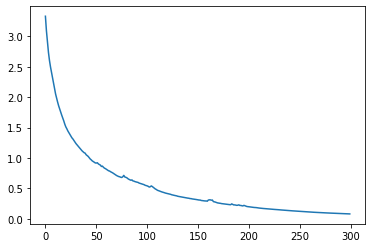

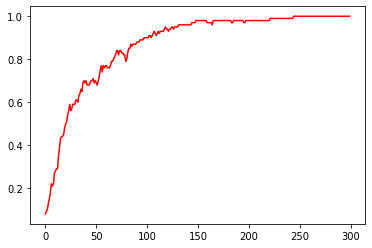

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history['loss'], label='loss')
plt.show()
plt.plot(history['acc'], 'r', label='accuracy')
plt.show()